In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from skimage.util.shape import view_as_windows
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import itertools

In [2]:
# Read in the averaged vector field data.  

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/U_avg.h5", "r") as file: 
    U = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/V_avg.h5", "r") as file: 
    V = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/M_avg.h5", "r") as file: 
    M = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/xgrid_matrix", "r") as file: 
    xgrid = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/ygrid_matrix", "r") as file: 
    ygrid = file["matrix"][:]

One 0.69 μm/pixel and 10 min/frame

In [3]:
pixel_factor = 0.69  # μm
time_factor = 10  # min

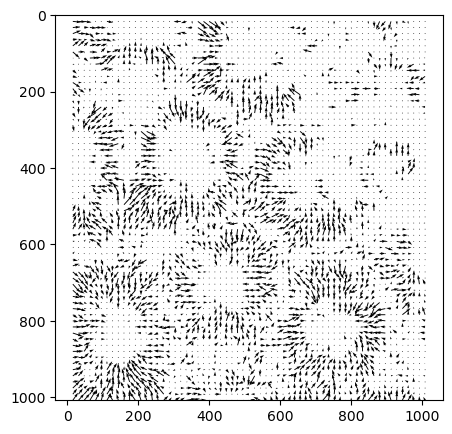

In [4]:
t = 150

plt.figure(figsize=(5, 5))
plt.quiver(xgrid[t], ygrid[t], V[t], -U[t])
plt.ylim(max(ygrid[t][1]), 0)
plt.show()

In [5]:
x_test = xgrid[0][7:34, 12:39]
y_test = ygrid[0][7:34, 12:39]
U_test = U[t][7:34, 12:39]
V_test = V[t][7:34, 12:39]
M_test = M[t][7:34, 12:39]

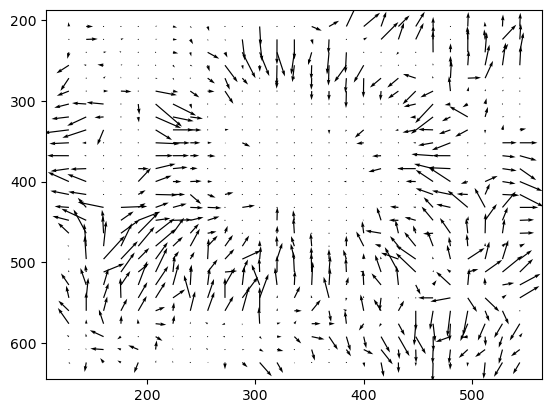

In [6]:
plt.quiver(x_test, y_test, V_test, -U_test)
plt.gca().invert_yaxis()

# The velocity profile

In [7]:
def get_window_sum(ar, W, i, j):
    # For a given 2D numpy array "ar" extract at the index i,j the subarray with size W = (a, b).
    # Finally return the mean value of the window. 
    # Out of boundary regions are filled by 0.
    h0,h1 = (W[0]-1)//2, (W[1]-1)//2 
    ar_ext = np.pad(ar,((h0,h0),(h1,h1)),'constant',constant_values=(0,0))
    window = view_as_windows(ar_ext, (W[0],W[1]))[i,j]
    return np.sum(window)

In [10]:
def velocity_cal(sub_M): 
    # The dimension of sub_M must be uneven, such that a center can be easily defined. 
    # The function generate the mean velocity for grid ring from distance to the center 0 to maximal distance.
    # The sum of the velocities in the grid ring with distance r to the center is the sum of matrix with radius r minus the one with r-1
    dim = np.shape(sub_M)
    center = tuple(round(i/2) for i in dim) # (c, c) tuple.
    max_radius = center[0] - 1

    mean_velocity = [sub_M[center[0], center[1]]]
    sum_velocity = [sub_M[center[0], center[1]]]
    
    for r in range(1, max_radius+1): 
        
        window_size = r*2 + 1 
        num_pixel = 8*r  # (2r+1)^2 - (2(r-1)+1)^2 = 8r
        
        # Calculate the sum of velocity within radius r.
        velocity_r = get_window_sum(sub_M, (window_size, window_size), center[0], center[1])
        sum_velocity.append(velocity_r)
        
        # Got the velocity in ring from radius r-1 to r.
        diff_velocity_r = sum_velocity[r] - sum_velocity[r-1]

        # Calculate the mean value in the ring. rescaled by the distance per pixel devided by frame duration.
        mean_velocity.append(diff_velocity_r/num_pixel)
        
    return np.array(mean_velocity)*pixel_factor/time_factor
    #return mean_velocity

In [9]:
velocity_cal(M_test)

[0.57982296,
 3.3403286933898926,
 5.583467960357666,
 7.343499501546224,
 11.879242897033691,
 14.775787353515625,
 19.691571553548176,
 19.586826869419642,
 24.06745147705078,
 24.457411024305557,
 19.8200439453125,
 19.032459605823863,
 21.288930257161457,
 10.970487154447115]

In [13]:
def velocity_ring(sub_M, r, center): 
    # Extract the velocity from the grid ring that has the distance to the center.
    
    x = center[0]
    y = center[1]

    # Geather the positions in the ring with distance r to the center. 
    ring_pos = []
    for i in range(-r, r+1): 
        ring_pos.append((x+r, y+i))
        ring_pos.append((x-r, y+i))
        ring_pos.append((x+i, y+r))
        ring_pos.append((x+i, y-r))
    ring_pos = list(set(ring_pos))

    # Gather the velocity in the ring_pos.
    velocity = []
    # distance = [r*16*pixel_factor]*len(ring_pos) # If using scatter plot.
    for pos in ring_pos:
        velocity.append(sub_M[pos[0], pos[1]]*pixel_factor/time_factor)

    return np.mean(np.array(velocity)), np.std(np.array(velocity))

In [78]:
velocity_ring(M_test, 2, (14, 14))

(0.3852592959478498, 0.6033450265173678)

In [14]:
def mean_std_velocity(sub_M): 
    # Gather all velocities in the grid ring with distance 0 to maximal to the center. 
    
    dim = np.shape(sub_M)
    center = tuple(round(i/2) for i in dim) # (c, c) tuple.
    max_radius = center[0] - 1

    # Gather the mean and std velocity.
    mean_vel = np.zeros(max_radius)
    std_vel = np.zeros(max_radius)
    for r in range(max_radius): 
        mean, std = velocity_ring(sub_M, r, center)
        mean_vel[r] = mean
        std_vel[r] = std
    return mean_vel, std_vel

    # all_velocity = []
    # distance = []
    # for r in range(max_radius): 
    #     vel, dist = velocity_ring(sub_M, r, center)
    #     all_velocity.append(vel)
    #     distance.append(dist)
    # return all_velocity, distance

In [95]:
mean, std = mean_std_velocity(M_test)
mean

array([0.04000778, 0.23048267, 0.3852593 , 0.50670156, 0.81966768,
       1.01952928, 1.35871885, 1.35149088, 1.66065393, 1.68756122,
       1.3675836 , 1.31323905, 1.46893659])

In [86]:
radius = [i*16*pixel_factor for i in range(len(mean))]
radius

[0.0,
 11.04,
 22.08,
 33.12,
 44.16,
 55.199999999999996,
 66.24,
 77.28,
 88.32,
 99.35999999999999,
 110.39999999999999,
 121.44,
 132.48]

### Plot the velocity profile for one aggregate comparing two different time points.

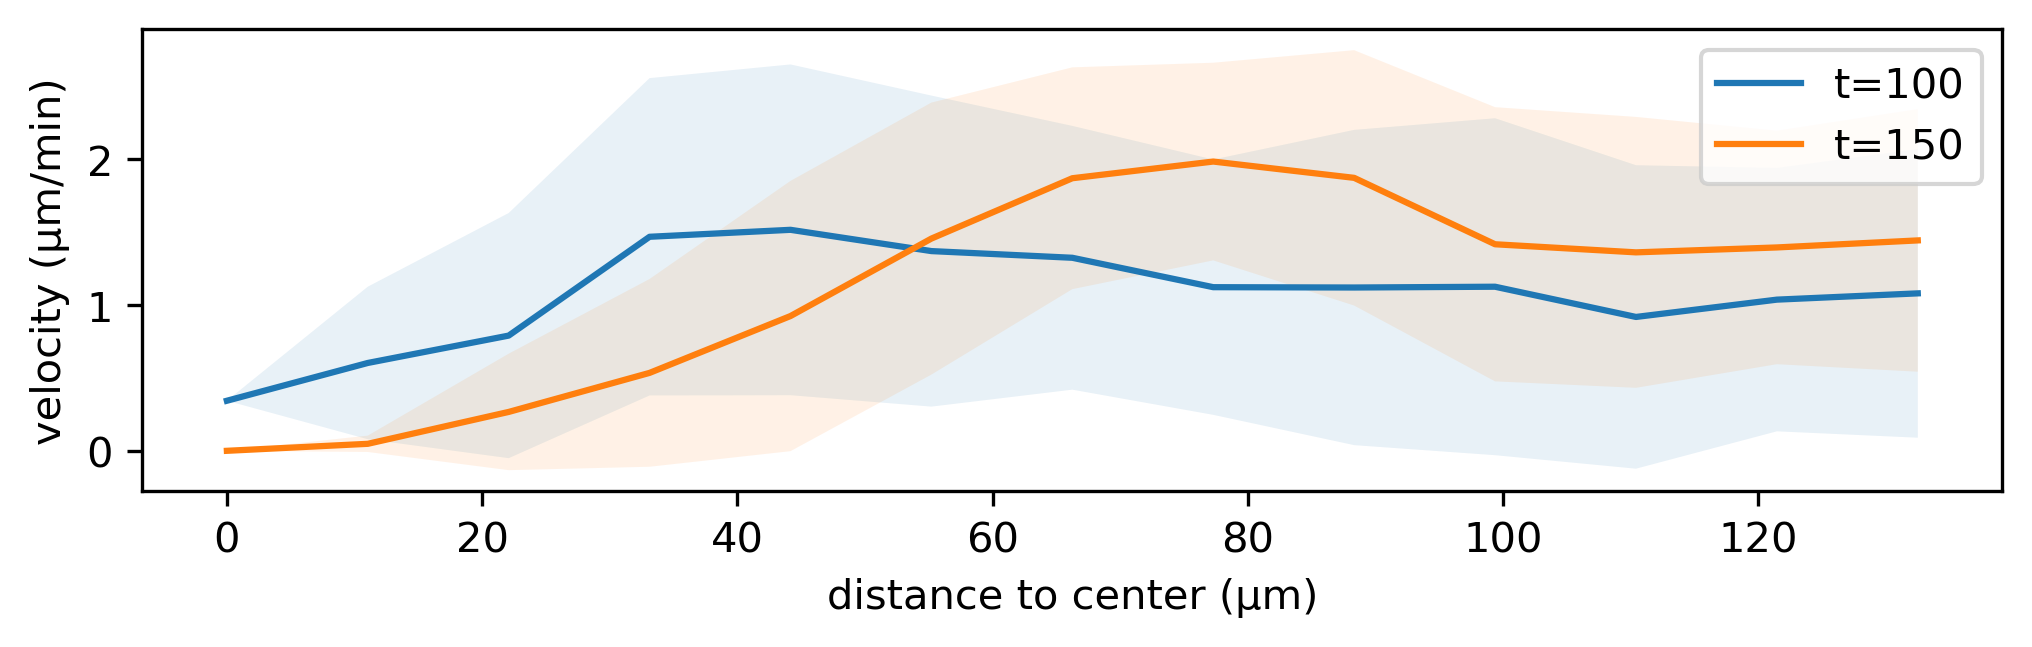

In [22]:
plt.figure(figsize=(8, 2), dpi=300)
for t in [100, 150]: 
    sub_M = M[t][32:59, 37:64]
    
    # Plot the mean and shaded with std.
    mean, std = mean_std_velocity(sub_M)
    radius = [i*16*pixel_factor for i in range(len(mean))]
    plt.plot(radius, mean, label = "t="+str(t))
    plt.fill_between(radius, mean-std, mean+std, alpha = 0.1)

    # Plot the mean
    # mean_v = velocity_cal(sub_M)
    # radius_pixel = [i*16*pixel_factor for i in range(len(mean_v))]
    # plt.plot(radius_pixel, mean_v, label = "t="+str(t))

    # # Background the scatter plot of the single velocity distribution. --> the scatter at the background not visiable.
    # all_vel, dist = single_velocity(sub_M)
    # all_vel = list(itertools.chain.from_iterable(all_vel))
    # dist = list(itertools.chain.from_iterable(dist))
    # plt.scatter(dist, all_vel, alpha=0.1)
plt.ylabel("velocity (μm/min)")
plt.xlabel("distance to center (μm)")
plt.legend()
plt.savefig("velocity_profile_agg_3")
plt.show()

### Make video for the velocity profile for one aggregate.

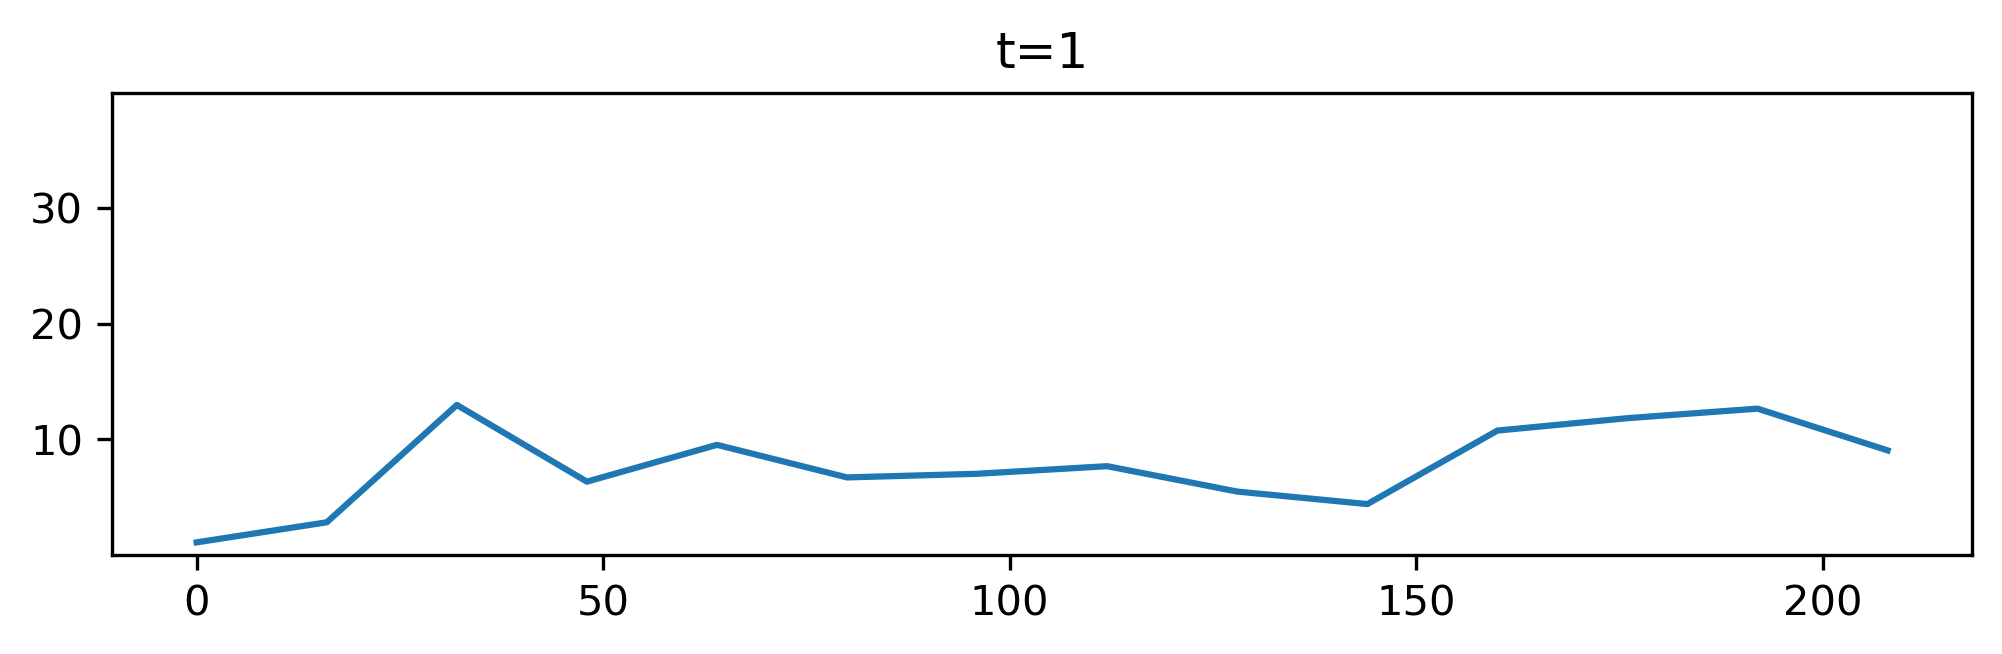

In [5]:
fig = plt.figure(figsize=(8, 2), dpi=300)
def make_frame(t): 
    plt.clf()

    mean_v = velocity_cal(M[t][32:59, 37:64])
    radius_pixel = [i*16 for i in range(len(mean_v))]
    plt.plot(radius_pixel, mean_v)
    plt.ylim(0, 40)
    plt.yticks([10, 20, 30], [10, 20, 30])
    plt.title("t=" + str(t+1))

myanim = FuncAnimation(fig, make_frame, frames = np.shape(U)[0]-1, interval = 500) 
myanim.save("velocity_profile_agg_3.mp4", writer="ffmpeg")

# The collective movement profile

Caution: have to consider the bias that in the ring with larger radius, the neighbours are more parallel than the ones nearer to the center. 

The calculation follows with:

1) The orientation score between two vectors are the dot product between (normalized) vectors. Reults values between -1 and 1.
2) For the point in (i, j) position, calculate the orientation score of it with all surrounding neighbour vectors pairweise and sum them up. There are 8 neighbours, each between [-1, 1]. Normalize the final sum by 8.
3) For the points in the ring with radius r, sum up all 8r orientation scores and normalized by 8r.

In [6]:
def orientation_vectors(U, V, M, p1, p2): 
    # Calculate the normalized dot prodoct between two vectors on the positions p1 = (x1, y1) and p2 = (x2, y2).
    
    # calculate the dot product of two vectors.
    dot_prod = U[p1[0], p1[1]]*U[p2[0], p2[1]] + V[p1[0], p1[1]]*V[p2[0], p2[1]]
    # Normalization of the dot product. 
    nor_dot_prod = dot_prod / (M[p1[0], p1[1]] * M[p2[0], p2[1]])
    return nor_dot_prod

In [7]:
orientation_vectors(U_test, V_test, M_test, (14, 14), (14, 15))

-0.29790002

In [7]:
def orientation_neighbour(U, V, M, center): 
    # Calculate the normalized sum of dot product between center and all 8 neighbour vectors. 
    # Represent the orientation score for the center vector. 

    # The list of neighbours surrounding the center. 
    x = center[0]
    y = center[1]
    neighbours = [(x-1, y), (x+1, y), (x, y-1), (x, y+1), (x+1, y+1), (x+1, y-1), (x-1, y+1), (x-1, y-1)]

    # sum up all orientation scores between center and other neighbours. 
    score_sum = 0
    for p in neighbours: 
        score_sum += orientation_vectors(U, V, M, center, p)
    # Normalize the score sum durch the number of neighbours 8.
    nor_orient_score = score_sum/len(neighbours) 

    return nor_orient_score

In [10]:
orientation_neighbour(U_test, V_test, M_test, (20, 14))

0.9383526295423508

In [8]:
def orientation_ring(U, V, M, r, center):
    # Calculate the normalized orientation score in the ring with distance r to aggregate center. 
    # Represents the orientation score for the ring. 
    x = center[0]
    y = center[1]

    # Geather the positions in the ring with distance r to the center. 
    ring_pos = []
    for i in range(-r, r+1): 
        ring_pos.append((x+r, y+i))
        ring_pos.append((x-r, y+i))
        ring_pos.append((x+i, y+r))
        ring_pos.append((x+i, y-r))
    ring_pos = list(set(ring_pos))

    # sum up the orientation score for each ring position and normalize it by the number of elements 8r. 
    orient_sum = 0
    for p in ring_pos:
        orient_sum += orientation_neighbour(U, V, M, p)
    # Normalize it by the number of ring elements. 
    nor_orient_score = orient_sum/len(ring_pos)

    return nor_orient_score

In [18]:
orientation_ring(U_test, V_test, M_test, 9, (14, 14))

0.662642616589033

In [9]:
def orientation_aggregate(sub_U, sub_V, sub_M): 
    # Calculate the orientation score profile for an aggregate in dependence of the distance to center. 

    # Get the center and the maximal distance to center. 
    dim = np.shape(sub_U)
    center = tuple(round(i/2) for i in dim) # (c, c) tuple.
    max_dist = center[0] - 1

    # The orientation score in dependence of the distance to center. (without considering the boundary). 
    orient_r = []
    for r in range(1, max_dist-1): 
        orient_r.append(orientation_ring(sub_U, sub_V, sub_M, r, center))
    return orient_r

In [27]:
orientation_aggregate(U_test, V_test, M_test)

[0.19027685397304595,
 0.5922426150063984,
 0.6799018089125942,
 0.7122852483880706,
 0.8290484014432877,
 0.8863261130948862,
 0.8530807461772513,
 0.730881177826177,
 0.5962563918061884,
 0.5691203758440679,
 0.6312462065305392]

### Plot the orientation profile for one aggregate comparing two different time points.

In [10]:
# plt.figure(figsize=(8, 2), dpi=300)
# for t in [50, 100]: 
#     orient_score = orientation_aggregate(U[t][7:34, 12:39],
#                                         V[t][7:34, 12:39],
#                                         M[t][7:34, 12:39])
#     radius_pixel = [i*16 for i in range(1, len(orient_score)+1)]
#     plt.plot(radius_pixel, orient_score, label = "t="+str(t))
# plt.legend()
# plt.savefig("orientation_profile_agg_1")
# plt.show()

### Make video for the orientation profile for one aggregate.

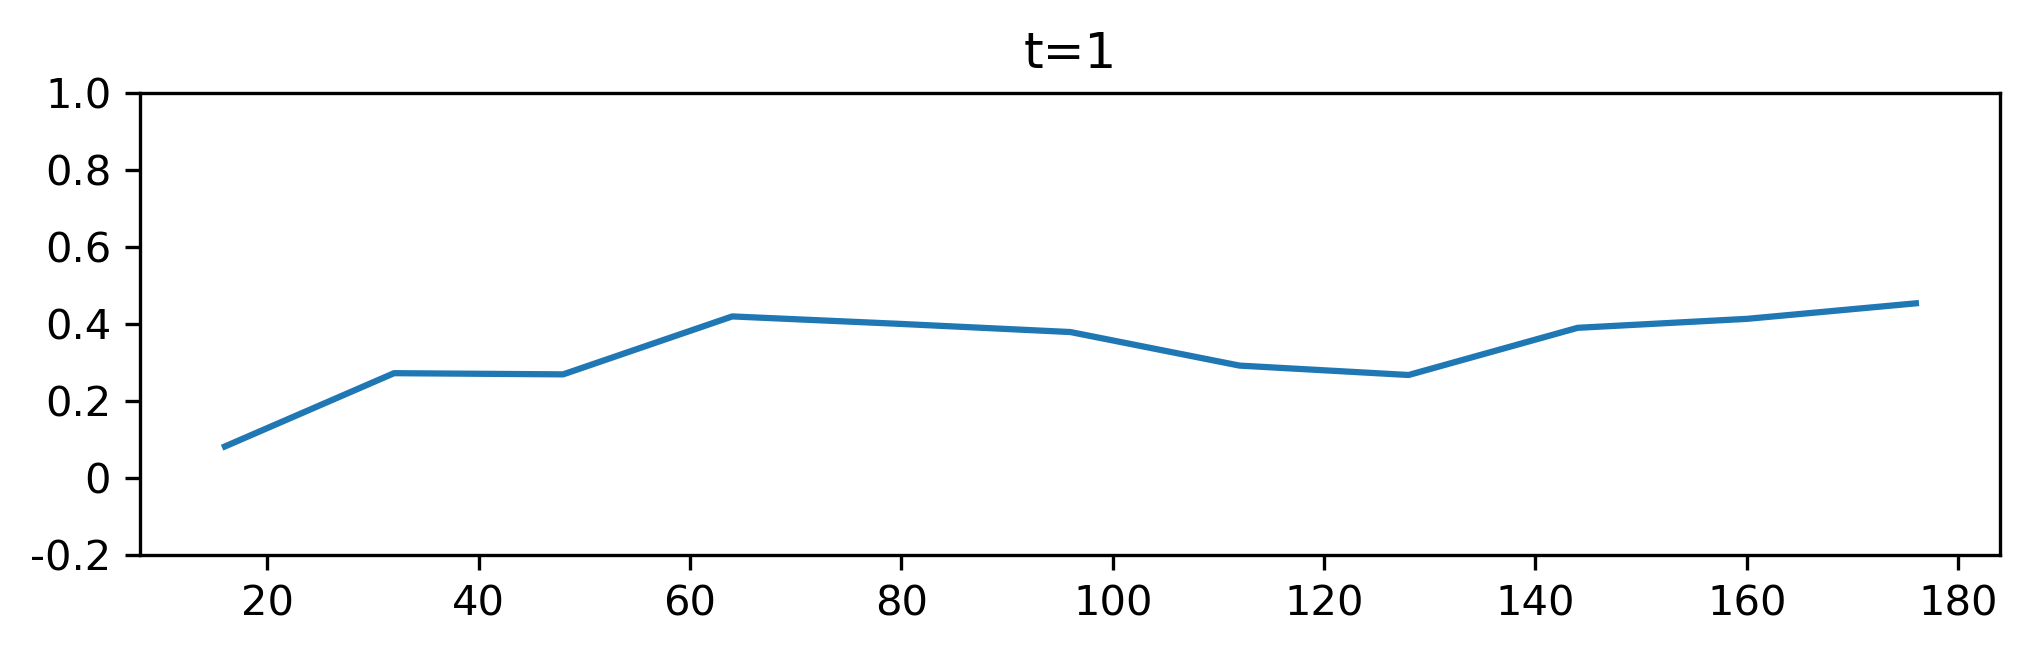

In [14]:
fig = plt.figure(figsize=(8, 2), dpi=300)
def make_frame(t): 
    plt.clf()

    orient_score = orientation_aggregate(U[t][32:59, 37:64],
                                        V[t][32:59, 37:64],
                                        M[t][32:59, 37:64])
    radius_pixel = [i*16 for i in range(1, len(orient_score)+1)]
    plt.plot(radius_pixel, orient_score)
    plt.ylim(-0.2, 1.0)
    plt.yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0], [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.title("t=" + str(t+1))

myanim = FuncAnimation(fig, make_frame, frames = np.shape(U)[0]-1, interval = 500) 
myanim.save("orientation_profile_agg_3.mp4", writer="ffmpeg")